In [1]:
!aws s3 cp s3://spendclassification-data-832858300172/spend_data.csv .

download: s3://spendclassification-data-832858300172/spend_data.csv to ./spend_data.csv


In [2]:
!ls

archive		 credentials		      lost+found  spend_data.csv
BI_Bayer8.ipynb  Deep_learning_Pytorch.ipynb  out


In [3]:
!pip install wordcloud
!pip install nltk
!pip install missingno

# for data
import pandas as pd

# for missing values
import missingno as msno

# for plotting
import matplotlib.pyplot as plt

# for word frequency
from wordcloud import WordCloud

import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize

     |████████████████████████████████| 366 kB 13.3 MB/s eta 0:00:01
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


In [4]:
df = pd.read_csv("spend_data.csv")

# Exploratory Data Analysis (EDA)

## General observations
We have mostly categorical data in our dataset apart from the 'value' attribute, which is re-scaled by min-max normalization. (The 'Unnamed' column is not a feature, it contains the row indices). The text field attribute contains unstructured text data. Missing attribute values: in case of 'accounting_item_nr_text', 'material_number_text', 'material_number' more than 99% of the data is missing -> we dropped these attributes. We dropped further attributes based on domain knowledge as they are not (always) available before classification.
The remaining missing values in 'division' attribute are proven to be MAR (Missing at Random -> likelihood of missing is related to some of the observed data -> in our case profit_center). MAR is safe to remove the missing data without producing bias in the model and we have a large enough dataset to do that so we dropped the related rows.

In [5]:
# check the dimensions of the data

print(df.shape)
df.head()

(411688, 22)


,Unnamed: 0,division,company_code,material_number,plant,text,profit_center,value,vendor,target_material_group,...,document_number,accounting_doc_nr,accounting_item_nr,division_text,material_number_text,plant_text,target_material_group_text,subcategory_text,gl_account_text,accounting_item_nr_text
0,0,A0,BAY1251,NaN,BAYSG20,APPLE IPHONE SE SPACEGRAU (SOLO),BAYTS00000192,0.000114,BAY7687151,BAY19060000,...,-2283150718655914175,6677086303443476074,BAY4,Bayer Business/Köln,NaN,BBS Leverkusen,Hardware communication technology,Assets,Low Value Fixed Assets Expense,NaN
1,1,AC,BAY1230,NaN,BAYBY9F,OFFICE DEPOT KOMPATIBEL LEXMARK 64036HE,BAYTBP0000448,0.000061,BAY7563120,BAY24200000,...,2161231112793983546,-5881031502641120183,BAY45,Bayer CropScience/Monheim,NaN,BAG CS Dormagen Technik,Office supplies,Office Supplies,IT and office supplies,NaN
2,2,AA,BAY2001,NaN,BAYGV2Z,LEITZ LOCHER NEXXT 50380095,BAYTBA0000274,0.000005,BAY1661150,BAY24200000,...,-7133917197646183671,7697684432735867063,BAY27,Bayer Pharma/Berlin,NaN,Bayer AG Berlin Technik,Office supplies,Office Supplies,IT and office supplies,NaN
3,3,AA,BAY0948,NaN,BAYB208,BLOCCHI SPIRALATI PIGNA PIGNASTYL A4 AS,BAYTBP0000275,0.000006,BAY8484267,BAY24200000,...,-2793929148281548543,-6849623173500875118,BAY22,Bayer HealthCare/Italy,NaN,SRM Segrate,Office supplies,Office Supplies,GR/IR Clearing - Non Inventory (MM),NaN
4,4,AA,BAY2174,NaN,BAYJ62Z,LOMAKELAATIKKO PALASET P-0901,BAYTBD0000274,0.000034,BAY6515523,BAY24200000,...,7585342434188576837,5431898765055576616,BAY3,Bayer/Finland,NaN,Bayer Oy Turku MRO,Office supplies,Office Supplies,IT and office supplies,NaN


In [6]:
df.columns

Index(['Unnamed: 0', 'division', 'company_code', 'material_number', 'plant',
       'text', 'profit_center', 'value', 'vendor', 'target_material_group',
       'subcategory', 'gl_account', 'document_number', 'accounting_doc_nr',
       'accounting_item_nr', 'division_text', 'material_number_text',
       'plant_text', 'target_material_group_text', 'subcategory_text',
       'gl_account_text', 'accounting_item_nr_text'],
      dtype='object')

In [7]:
# check data from the value coloumn -> normalized by min-max

df['value'].describe()

count    411688.000000
mean          0.000180
std           0.003071
min           0.000000
25%           0.000004
50%           0.000009
75%           0.000033
max           1.000000
Name: value, dtype: float64

In [8]:
# calculate missing values statistics

def null_values(df):
        mis_val = df.isnull().sum()
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        print ("Dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        return mis_val_table_ren_columns
    
miss_values = null_values(df)
miss_values.head(10)

Dataframe has 22 columns.
There are 7 columns that have missing values.


,Missing Values,% of Total Values
accounting_item_nr_text,411688,100.0
material_number_text,409108,99.4
material_number,409107,99.4
division,6478,1.6
subcategory,2764,0.7
subcategory_text,2764,0.7
plant_text,1578,0.4


In [9]:
# drop columns based on missing values statistics - accounting_item_nr_text, material_number_text, material_number > 99% of missing values

df = df.drop(columns=['accounting_item_nr_text', 'material_number_text', 'material_number'])

print(df.shape)

(411688, 19)


In [10]:
# drop columns based on domain knowledge -> subcategory, gl_account, document_number, accounting_doc_nr, accounting_item_nr, 
# subcategory_text, gl_account_text data are not (always) known prior the classification

df = df.drop(columns=['subcategory','gl_account','document_number','vendor','accounting_item_nr','accounting_doc_nr','subcategory_text',
                      'gl_account_text','division_text','plant_text'])

print(df.shape)
df.head()

(411688, 9)


,Unnamed: 0,division,company_code,plant,text,profit_center,value,target_material_group,target_material_group_text
0,0,A0,BAY1251,BAYSG20,APPLE IPHONE SE SPACEGRAU (SOLO),BAYTS00000192,0.000114,BAY19060000,Hardware communication technology
1,1,AC,BAY1230,BAYBY9F,OFFICE DEPOT KOMPATIBEL LEXMARK 64036HE,BAYTBP0000448,0.000061,BAY24200000,Office supplies
2,2,AA,BAY2001,BAYGV2Z,LEITZ LOCHER NEXXT 50380095,BAYTBA0000274,0.000005,BAY24200000,Office supplies
3,3,AA,BAY0948,BAYB208,BLOCCHI SPIRALATI PIGNA PIGNASTYL A4 AS,BAYTBP0000275,0.000006,BAY24200000,Office supplies
4,4,AA,BAY2174,BAYJ62Z,LOMAKELAATIKKO PALASET P-0901,BAYTBD0000274,0.000034,BAY24200000,Office supplies


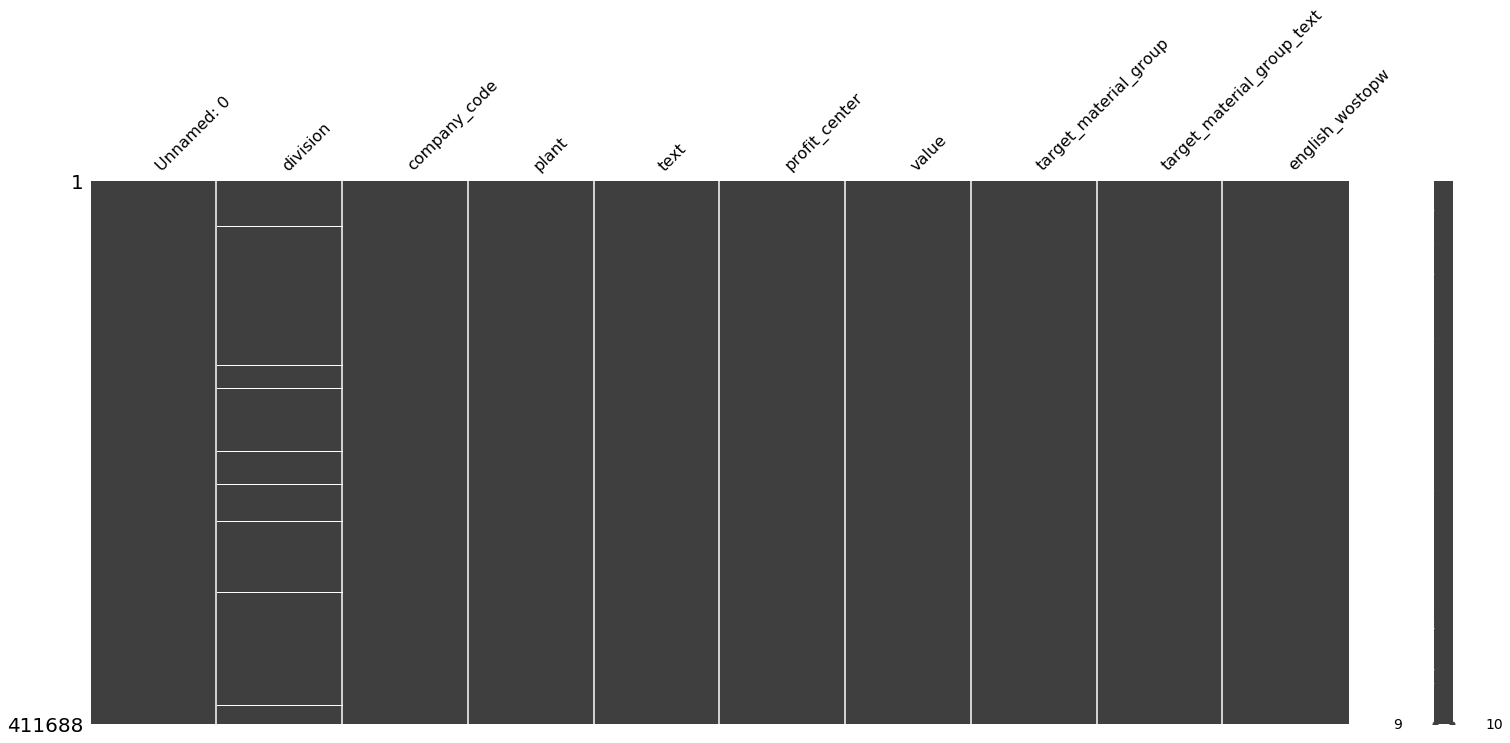

In [41]:
# check the missing values in 'division' -> MAR, MCAR or MNAR?

msno.matrix(df)

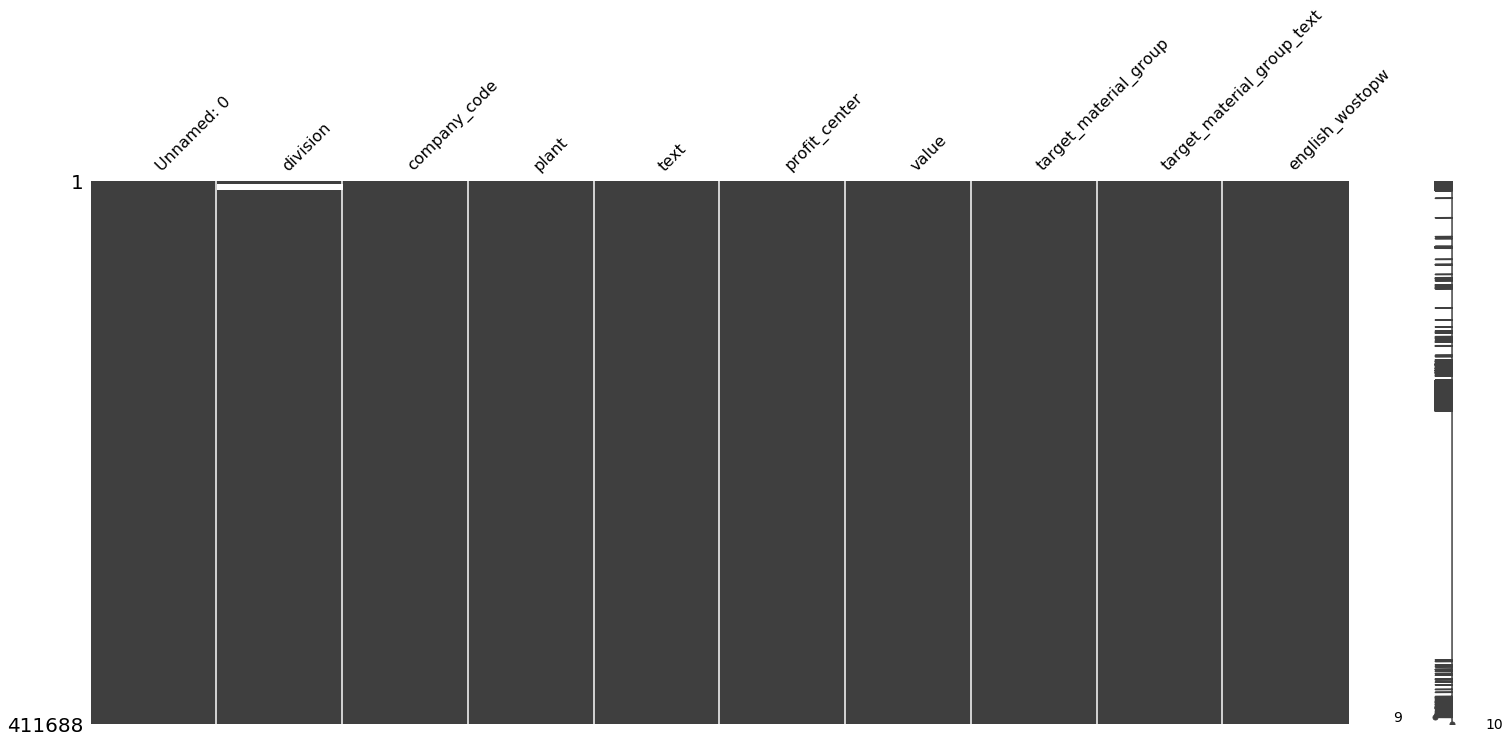

In [42]:
# MAR -> The likelihood of being missing depends on profit_center data -> it is safe to remove the missing data and we have a large enough
# dataset to do that

msno.matrix(df.sort_values('profit_center'))

In [44]:
# drop missing values

df = df.dropna()
df.shape

,Unnamed: 0,division,company_code,plant,text,profit_center,value,target_material_group,target_material_group_text,english_wostopw
0,0,A0,BAY1251,BAYSG20,APPLE IPHONE SE SPACEGRAU (SOLO),BAYTS00000192,0.000114,BAY19060000,Hardware communication technology,apple iphone se spacegrau
1,1,AC,BAY1230,BAYBY9F,OFFICE DEPOT KOMPATIBEL LEXMARK 64036HE,BAYTBP0000448,0.000061,BAY24200000,Office supplies,office depot compatible lexmark
2,2,AA,BAY2001,BAYGV2Z,LEITZ LOCHER NEXXT 50380095,BAYTBA0000274,0.000005,BAY24200000,Office supplies,leitz locher nexxt
3,3,AA,BAY0948,BAYB208,BLOCCHI SPIRALATI PIGNA PIGNASTYL A4 AS,BAYTBP0000275,0.000006,BAY24200000,Office supplies,spiral blocks pigna pignastyl
4,4,AA,BAY2174,BAYJ62Z,LOMAKELAATIKKO PALASET P-0901,BAYTBD0000274,0.000034,BAY24200000,Office supplies,form box pieces


## Sample questions

### Class distribution
We clearly have an imbalanced class problem here where the number of observations per class are not equally distributed. E.g., the number of purchase item requests belonging to "Office Supplies" is more than 8 650 times of "Mass storage (IT)" items. As conventional algorithms are often biased towards the majority class(es) this can lead to low accuracy in minority classes. In our case the value distribution adds further complexity as not the most populated classes account for the highest value. (The domain-experts expressed the wish for the higher value purchase requests to be classified more accuratly.)
There are several approaches to handle the imbalance class problem like cost function based approaches and sampling based approaches.

Office supplies                          164350
Printer                                  120822
Personal computer                         42303
Hardware communication technology         35178
Office equipment                          16661
Peripheral device                         14645
Network components (components)            4889
Server                                     4648
Office stamp                               3239
Media technology                           2601
Notebook PC and other non-standard PC      1345
Entertainment electronics                   465
Photo technology video technology           331
Scanner                                     192
Mass storage (IT)                            19
Name: target_material_group_text, dtype: int64
AxesSubplot(0.125,0.125;0.775x0.755)


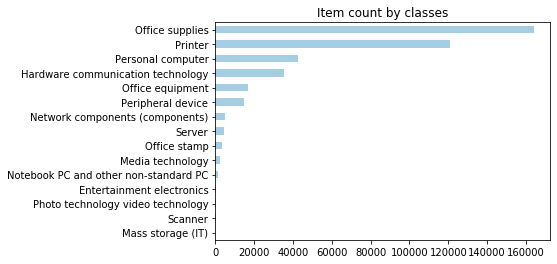

In [11]:
# 1. sample question: How many items are in which class? -> imbalanced classes

# item count by classes
print(df['target_material_group_text'].value_counts())

# plot it as a histogram
print(df['target_material_group_text'].value_counts().sort_values().plot(kind='barh',colormap='Paired',
                                                    y='value', x='target_material_group_text', 
                                                    legend=False, title= "Item count by classes"))


                                           value
target_material_group_text                      
Server                                 16.589823
Network components (components)        12.202190
Office equipment                       10.623312
Personal computer                       8.874571
Office supplies                         6.825776
Hardware communication technology       5.853182
Peripheral device                       3.638365
Printer                                 3.411417
Notebook PC and other non-standard PC   3.005932
Media technology                        1.840860
Mass storage (IT)                       0.657424
Scanner                                 0.398339
Photo technology video technology       0.158006
Entertainment electronics               0.136998
Office stamp                            0.057118
AxesSubplot(0.125,0.125;0.775x0.755)


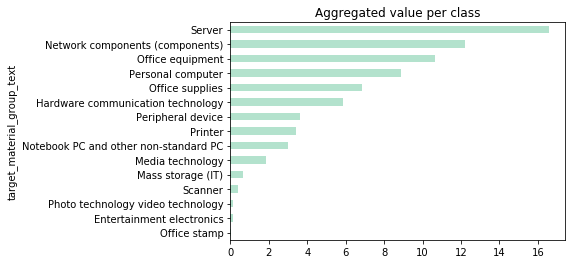

In [14]:
# 3. sample question: How is the value distribution per class?
# item count distribution per class -><- aggregated value distribution per class

# aggregated value per classes
print(df.groupby(['target_material_group_text'], sort=False).agg({'value': sum}).sort_values('value',ascending=False))


# plot it as a histogram
df_flat = df.groupby(['target_material_group_text'])['value'].sum().reset_index()
print(df_flat.sort_values(['value'], ascending=True).plot(kind='barh',colormap='Pastel2',
                                                     y='value', x='target_material_group_text', 
                                                     legend=False, title= "Aggregated value per class"))
 


## Class distribution (After text attribute "transformation")
After doing the necessary preprocessing we can further explore our text data.
We can observe the most salient word tokens for each class with using wordclouds as visualization.
Each class has its own key-token set, which we can leverage in our classification model.
However we can see that there are words which are prominent in more classes e.g. "service" in 'Scanner' and 'Server'
classes seems frequent -> this can lead to misclassification if we don't handle it (e.g. we can filter out words/terms which
are salient in more classes).

In [17]:
# load the pre-processed data

df = pd.read_csv("out/cleaned_data.csv")

print(df.shape)
df.head()

(411688, 10)


,Unnamed: 0,division,company_code,plant,text,profit_center,value,target_material_group,target_material_group_text,english_wostopw
0,0,A0,BAY1251,BAYSG20,APPLE IPHONE SE SPACEGRAU (SOLO),BAYTS00000192,0.000114,BAY19060000,Hardware communication technology,apple iphone se spacegrau
1,1,AC,BAY1230,BAYBY9F,OFFICE DEPOT KOMPATIBEL LEXMARK 64036HE,BAYTBP0000448,0.000061,BAY24200000,Office supplies,office depot compatible lexmark
2,2,AA,BAY2001,BAYGV2Z,LEITZ LOCHER NEXXT 50380095,BAYTBA0000274,0.000005,BAY24200000,Office supplies,leitz locher nexxt
3,3,AA,BAY0948,BAYB208,BLOCCHI SPIRALATI PIGNA PIGNASTYL A4 AS,BAYTBP0000275,0.000006,BAY24200000,Office supplies,spiral blocks pigna pignastyl
4,4,AA,BAY2174,BAYJ62Z,LOMAKELAATIKKO PALASET P-0901,BAYTBD0000274,0.000034,BAY24200000,Office supplies,form box pieces


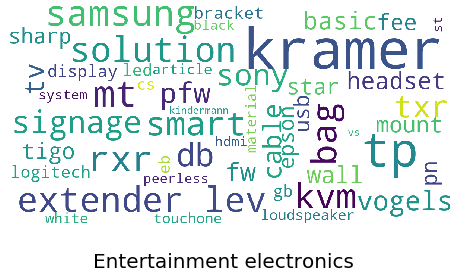

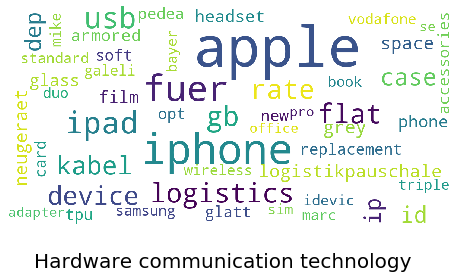

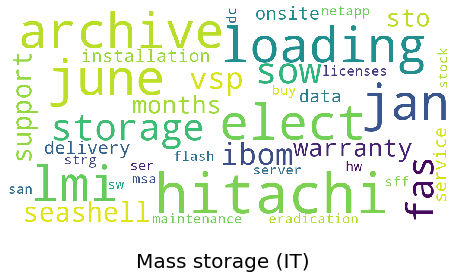

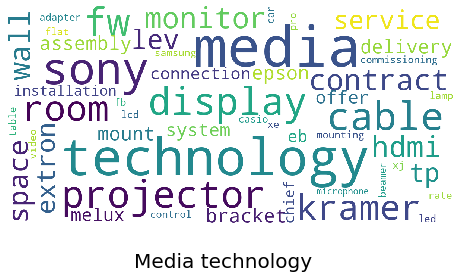

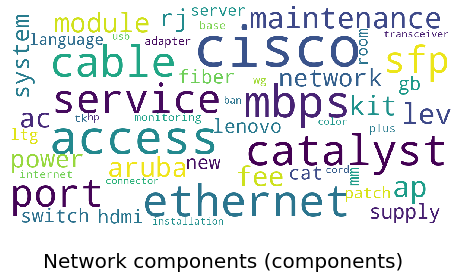

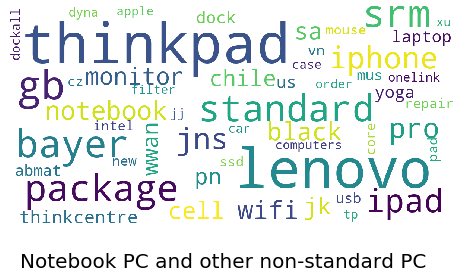

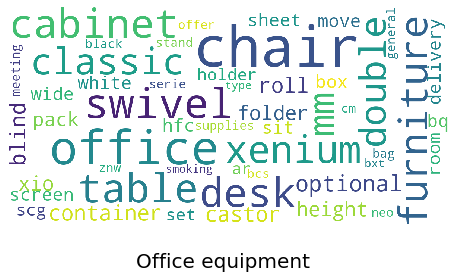

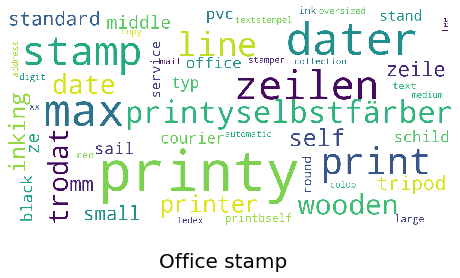

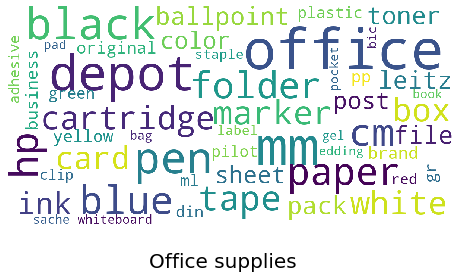

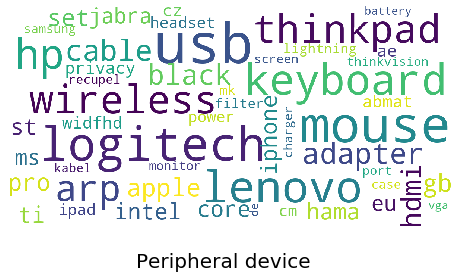

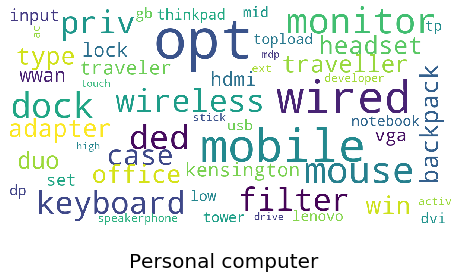

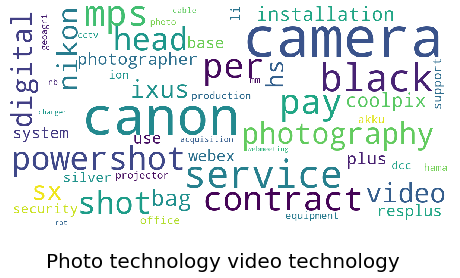

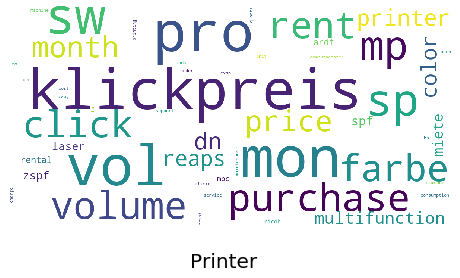

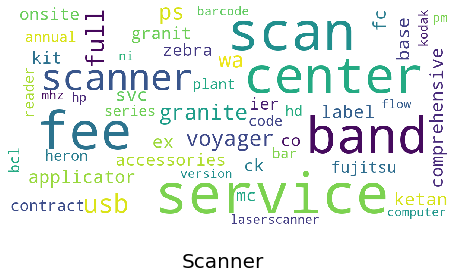

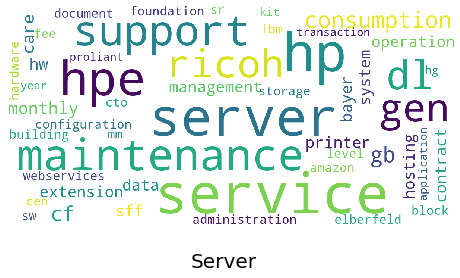

""


In [20]:
# create wordclouds per classes

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='white',
        max_words=50,
        max_font_size=50, 
        scale=3,
        collocations=False,
        random_state=1
    ).generate(str(data).replace("'",' '))

    fig = plt.figure(1, figsize=(8,8))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()



df.groupby('target_material_group_text').apply(lambda x: show_wordcloud(x.english_wostopw.tolist(), 
                                                                         title=f"{x.name}"))

In [47]:
# create word frequency table

df_most_common3 = df.groupby('target_material_group_text')['english_wostopw'].apply(lambda x: 
                                                                                    nltk.FreqDist(nltk.tokenize.word_tokenize(' '.join(
                                                                                        x))).most_common(3))

print(df_most_common3)

target_material_group_text
Entertainment electronics                              [(kramer, 89), (tp, 65), (rxr, 34)]
Hardware communication technology          [(apple, 20365), (iphone, 10517), (fuer, 6996)]
Mass storage (IT)                                 [(hitachi, 8), (loading, 6), (elect, 6)]
Media technology                            [(media, 314), (technology, 258), (sony, 190)]
Network components (components)                 [(cisco, 375), (access, 270), (mbps, 248)]
Notebook PC and other non-standard PC            [(lenovo, 260), (srm, 167), (bayer, 167)]
Office equipment                            [(chair, 1300), (office, 1053), (swivel, 815)]
Office stamp                                  [(printy, 1826), (dater, 1092), (max, 1080)]
Office supplies                             [(office, 13869), (mm, 12244), (depot, 10542)]
Peripheral device                           [(usb, 1802), (mouse, 1490), (logitech, 1277)]
Personal computer                            [(opt, 11420), (mo